In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import linregress
from windrose import WindroseAxes

sns.set(style="whitegrid")

In [42]:
# Chercher et formater vos données


C:\Users\masl0012\AppData\Local\Temp\ipykernel_20232\1223955908.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lyallbas.index = pd.to_datetime(lyallbas.index)


                        TAm    hr       1       2       3       0
Date                                                             
2025-11-08 09:45:01  10.956  55.0  15.652  15.605  15.103  15.891
2025-11-08 10:00:01  14.697  57.2  15.939  16.558  16.201  16.439
2025-11-08 10:15:01  15.008  47.8  13.714  14.457  14.601  12.074
2025-11-08 10:30:01  13.714  48.3  12.582  12.992  13.401  11.759
2025-11-08 10:45:01  13.281  49.3  11.880  12.485  12.775  11.200


In [43]:
# Chercher et formater les données WX


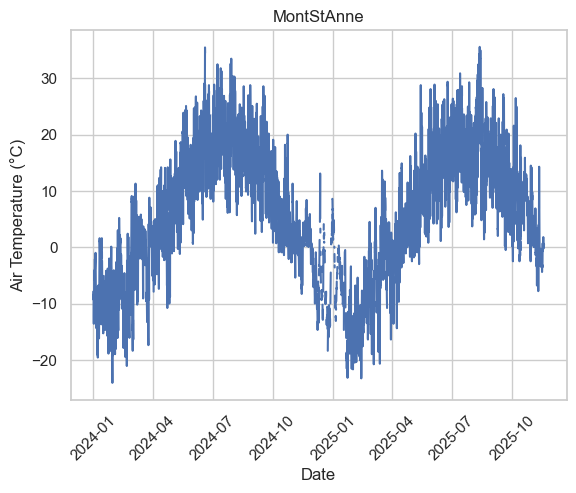

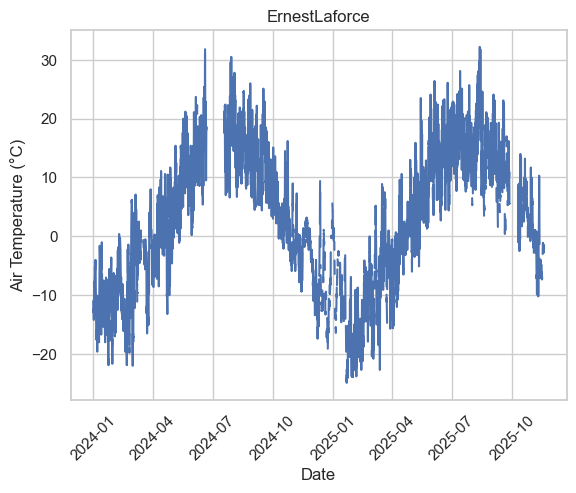

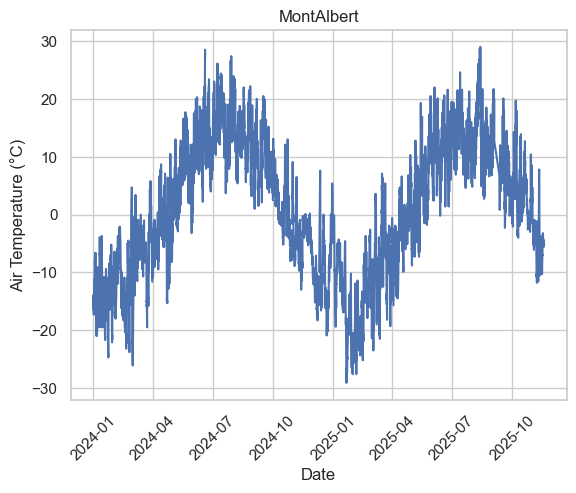

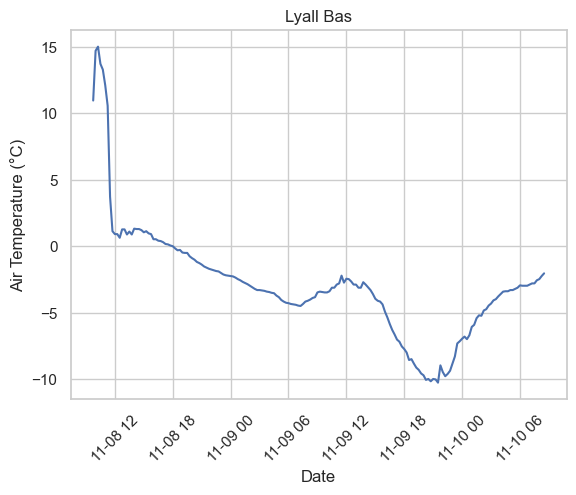

In [44]:
### Visualisation des données


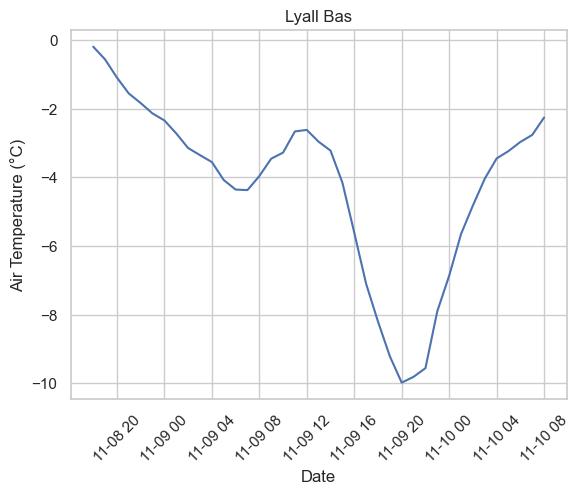

In [45]:
#Nettoyage des données


In [46]:
#Calculer le lapse rate pour les stations WX

def compute_hourly_lapse_rate(data, elevations):
    """
    Compute hourly lapse rate using reference stations.
    
    Parameters:
        data : dict
            {station: DataFrame with 'TAm'}
        elevations : dict
            {station: elevation_m}
            
    Returns:
        lapse : DataFrame with columns ['slope', 'intercept']
    """
    
    # Hourly resampling
    ref_data = {st: df["TAm"].resample("h").mean() for st, df in data.items()}
    combined = pd.DataFrame(ref_data)

    lapse = pd.DataFrame(index=combined.index, columns=["slope", "intercept"])

    # Loop on every hour
    for t, row in combined.iterrows():
        row_clean = row.dropna()
        if len(row_clean) < 2:
            continue

        X = np.array([elevations[st] for st in row_clean.index])
        y = row_clean.values

        slope, intercept, *_ = linregress(X, y)
        lapse.loc[t] = [slope, intercept]

    return lapse.astype(float)


                        slope  intercept
Date                                    
2024-01-01 00:00:00  0.007099 -15.806638
2024-01-01 01:00:00  0.007200 -16.006522
2024-01-01 02:00:00  0.007429 -16.391083
2024-01-01 03:00:00  0.007443 -16.633480
2024-01-01 04:00:00  0.007328 -16.691199
...                       ...        ...
2025-11-18 15:00:00  0.005431  -5.542015
2025-11-18 16:00:00  0.005445  -5.584412
2025-11-18 17:00:00  0.005688  -5.811370
2025-11-18 18:00:00  0.005803  -6.053650
2025-11-18 19:00:00  0.006120  -6.607650

[16508 rows x 2 columns]


In [47]:
# Estimer la température à une altitude x en utilisant le lapse rate et une station de votre choix

def estimate_temperature_from_lapse(lapse, dataWX, elevations, base_station, target_elevation):
    """
    Estimate temperature at a specific elevation using hourly lapse rate
    anchored to a base station.

    Parameters:
        lapse : pd.DataFrame
            DataFrame with columns ['slope', 'intercept'] per hour
        dataWX : dict
            Dictionary of DataFrames with 'TAm' for all stations
        elevations : dict
            Dictionary of elevations {station: elevation_m}
        base_station : str
            Name of the base station (e.g., 'MontAlbert')
        target_elevation : float
            Elevation (m) where temperature will be estimated

    Returns:
        pd.Series : Estimated temperatures at the target elevation
    """
    # Get hourly temperature at base station
    base_series = dataWX[base_station]["TAm"].resample("h").mean()
    base_elevation = elevations[base_station]

    # Prepare output
    estimates = pd.Series(index=lapse.index, dtype=float)

    dz = target_elevation - base_elevation

    for t in lapse.index:
        slope = lapse.loc[t, "slope"]
        T0 = base_series.loc[t]

        if pd.isna(slope) or pd.isna(T0):
            estimates.loc[t] = np.nan
        else:
            estimates.loc[t] = T0 + slope * dz

    return estimates


Date
2024-01-01 00:00:00   -12.583354
2024-01-01 01:00:00   -12.756059
2024-01-01 02:00:00   -12.994037
2024-01-01 03:00:00   -13.190320
2024-01-01 04:00:00   -13.321331
                         ...    
2025-11-18 15:00:00    -3.233655
2025-11-18 16:00:00    -3.229937
2025-11-18 17:00:00    -3.264198
2025-11-18 18:00:00    -3.433186
2025-11-18 19:00:00    -3.547541
Freq: h, Length: 16508, dtype: float64


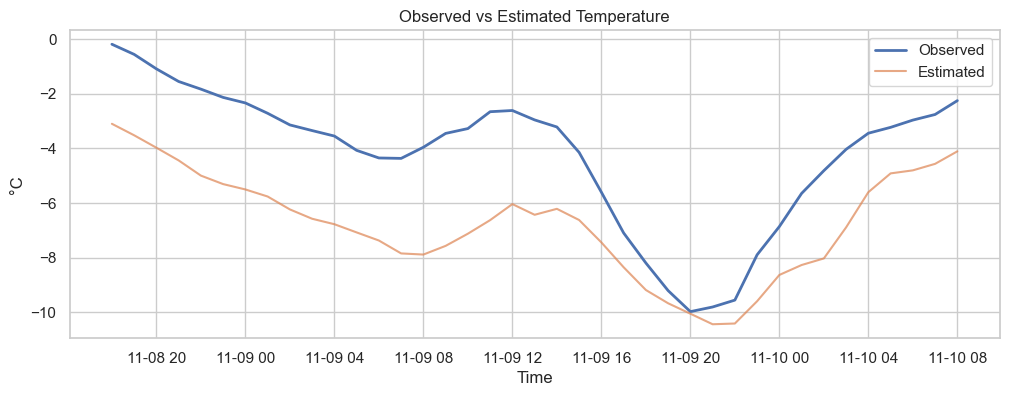

In [48]:
#Visualiser les TA estimées et mesurées

def plot_timeseries(estimates, observations):
    
    # restrict estimated temperatures to the observation period
    est = estimates.loc[observations.index.min():observations.index.max()]

    plt.figure(figsize=(12,4))
    plt.plot(observations, label="Observed", linewidth=2)
    plt.plot(est, label="Estimated", alpha=0.7)

    plt.title(f"Observed vs Estimated Temperature")
    plt.ylabel("°C")
    plt.xlabel("Time")
    plt.grid(True)
    plt.legend()
    plt.show()



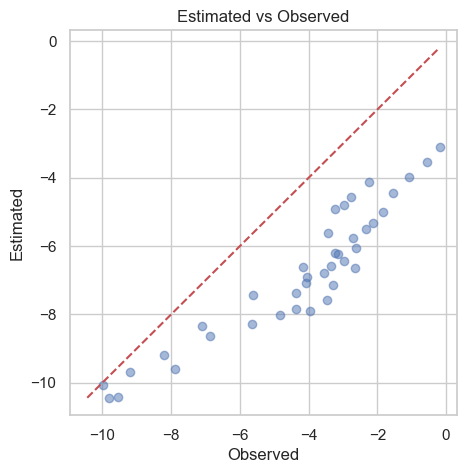

In [49]:
#Scatterplot pour validation

def plot_scatter(estimates, observations):
    
    est = estimates.reindex(observations.index)
    obs = observations

    mask = obs.notna() & est.notna()
    est = est[mask]
    obs = obs[mask]

    plt.figure(figsize=(5,5))
    plt.scatter(obs, est, alpha=0.5)
    
    # 1:1 line
    minv, maxv = min(obs.min(), est.min()), max(obs.max(), est.max())
    plt.plot([minv, maxv], [minv, maxv], 'r--')

    plt.xlabel("Observed")
    plt.ylabel("Estimated")
    plt.title(f"Estimated vs Observed")
    plt.grid(True)
    plt.show()

plot_scatter(test, lyallbas["TAm"])

In [51]:
#Calculer des indicateurs statistiques

def compute_accuracy(estimates, observations):
    """
    Compute RMSE, MAE, and Bias between estimated and observed temperatures.

    Parameters:
        estimates : pd.Series
            Estimated temperatures (indexed by time)
        observations : pd.Series
            Observed temperatures (indexed by time)
        station_name : str
            Name to label in the results

    Returns:
        pd.DataFrame : DataFrame with RMSE, MAE, Bias
    """
    # Align timestamps
    est_aligned, obs_aligned = estimates.align(observations, join="inner")

    # Compute metrics
    rmse = #################
    mae = ###############
    bias = #################

    return pd.DataFrame({"metrics": {"RMSE": rmse, "MAE": mae, "Bias": bias}}).T




,RMSE,MAE,Bias
metrics,2.736848,2.54132,-2.54132
